### Imports

In [1]:
!pip install pytrends
import pandas as pd
import numpy as np
import re
from datetime import datetime
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

### Loading in Google Trends data from PyTrends

In [2]:
# Set up pytrends
pytrends = TrendReq(hl='en-US', tz=360)

# Define query parameters
kw_list = ["Bitcoin"]  # Search term(s)
start_date = "2013-01-01"  # Start date
end_date = "2023-05-31"  # End date

# Build the payload
pytrends.build_payload(kw_list, timeframe=f"{start_date} {end_date}")

# Load in data
trends_data = pytrends.interest_over_time()

# Save the data to a CSV file
trends_data.to_csv('bitcoin_monthly_trends.csv')

# Extract

Here I extract data from three CSV files to create three dataframes.

### Data sources and credit

Two of the three data sources were downloaded from the internet, historical_bitcoin_data.csv and cryptonews.csv. historical_bitcoin_data was used because of its large volume of data and the source being reputable and frequently updated, the cryptonews.csv was used as its a public dataset and moreover was created using the publisher's API, Crypto News+, making this a repeatable project down the line with up-to-date data from both of these sources. Accessing APIs to obtain the relevant data at this stage is not possible due to free usage restrictions on APIs. 
The third data source I used is bitcoin_monthly_trends, this was created using the PyTrends module and can allow users to access monthly Google Trends data and can easily be exported as a csv.

The historical_bitcoin_data.csv file was downloaded from https://uk.investing.com/crypto/bitcoin/historical-data

The cryptonews.csv was downloaded from https://www.kaggle.com/datasets/oliviervha/crypto-news

In [3]:
df_news = pd.read_csv('cryptonews.csv')
df_bitcoin = pd.read_csv('historical_bitcoin_data.csv')
df_trends = pd.read_csv('bitcoin_monthly_trends.csv')

## Exploratory Data Analysis (EDA)

Here I explore the data in order to find out more about it from a macro sense. Some benefits of this include but are not limited to identifying patterns, assessing data quality, and feature selection.

For my three dataframes I carry out the following steps:

1. Check the datatypes
2. Check the dimensions of the dataframe
3. Check for missing values
4. Check for duplicate rows
5. Look at the head and tail of the dataframe
6. Look at basic summary statistics for the dataframe

### EDA on news dataframe

In [4]:
print(df_news.dtypes)

date         object
sentiment    object
source       object
subject      object
text         object
title        object
url          object
dtype: object


In [5]:
# Check the dimensions of the dataframe (rows, columns)
print(df_news.shape)

(18543, 7)


In [6]:
# Get an overview of the columns and their data types
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18543 entries, 0 to 18542
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       18543 non-null  object
 1   sentiment  18543 non-null  object
 2   source     18543 non-null  object
 3   subject    18543 non-null  object
 4   text       18543 non-null  object
 5   title      18543 non-null  object
 6   url        18543 non-null  object
dtypes: object(7)
memory usage: 1014.2+ KB


In [7]:
# Check for missing values
print(df_news.isnull().sum())

date         0
sentiment    0
source       0
subject      0
text         0
title        0
url          0
dtype: int64


In [8]:
# Check for duplicate rows
duplicate_rows = df_news[df_news.duplicated()]
if duplicate_rows.empty:
    print("No duplicate values found in df_news")
else:
    print("Duplicate values found in df_news:")
    print(duplicate_rows)

No duplicate values found in df_news


In [9]:
df_news.head()

,date,sentiment,source,subject,text,title,url
0,2023-04-05 06:52:09,"{'class': 'negative', 'polarity': -0.03, 'subj...",CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,https://cointelegraph.com/news/allbridge-to-fi...
1,2023-04-05 06:19:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,https://cryptopotato.com/bitcoin-hodl-patterns...
2,2023-04-05 05:09:44,"{'class': 'negative', 'polarity': -0.04, 'subj...",CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,https://cointelegraph.com/news/eth-hits-7-mont...
3,2023-04-05 01:09:52,"{'class': 'positive', 'polarity': 0.07, 'subje...",CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",https://cointelegraph.com/news/marathon-digita...
4,2023-04-04 23:49:00,"{'class': 'positive', 'polarity': 0.4, 'subjec...",CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,https://cryptopotato.com/brazilian-finance-gia...


In [10]:
df_news.tail()

,date,sentiment,source,subject,text,title,url
18538,2021-10-27 15:17:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,defi,Cream Finance (CREAM) suffered another flash l...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...
18539,2021-10-19 13:39:00,"{'class': 'positive', 'polarity': 0.1, 'subjec...",CryptoNews,blockchain,Banque de France disclosed the results of its ...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...
18540,2021-10-18 13:58:00,"{'class': 'positive', 'polarity': 0.14, 'subje...",CryptoNews,blockchain,Advancing its project to become \x9caÂ\xa0meta...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...
18541,2021-10-15 00:00:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,Chinese companies are still topping the blockc...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...
18542,2021-10-12 20:00:00,"{'class': 'positive', 'polarity': 0.16, 'subje...",CryptoNews,blockchain,"Within a little more than a year, Celo aims to...","Celo to Be Fastest EVM Chain by End of 2022, C...",https://cryptonews.com/news/celo-to-be-fastest...


In [11]:
# Compute basic summary statistics for numeric columns
df_news.describe()

,date,sentiment,source,subject,text,title,url
count,18543,18543,18543,18543,18543,18543,18543
unique,18304,3196,3,6,18131,18511,18543
top,2022-01-14 00:00:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,bitcoin,"Get your daily, bite-sized digest of cryptoass...",Is it Too Late to Buy Shiba Inu? Crypto Expert...,https://cointelegraph.com/news/robinhood-makes...
freq,26,4195,8675,6439,326,4,1


### EDA on Bitcoin price dataframe

In [12]:
print(df_bitcoin.dtypes)

Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [13]:
# Check the dimensions of the dataframe (rows, columns)
df_bitcoin.shape

(3800, 7)

In [14]:
# Check for missing values
print(df_bitcoin.isnull().sum())

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [15]:
duplicate_rows = df_bitcoin[df_bitcoin.duplicated()]
if duplicate_rows.empty:
    print("No duplicate values found in df_bitcoin")
else:
    print("Duplicate values found in df_bitcoin:")
    print(duplicate_rows)

No duplicate values found in df_bitcoin


In [16]:
df_bitcoin.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"May 28, 2023","27,226.1","26,855.3","27,315.4","26,788.5",32.87K,1.37%
1,"May 27, 2023","26,857.5","26,711.2","26,882.9","26,591.2",18.68K,0.55%
2,"May 26, 2023","26,711.5","26,475.5","26,911.6","26,330.0",45.88K,0.89%
3,"May 25, 2023","26,475.8","26,327.1","26,589.2","25,892.5",50.17K,0.56%
4,"May 24, 2023","26,328.4","27,220.7","27,220.7","26,088.7",72.65K,-3.28%


In [17]:
df_bitcoin.tail()

,Date,Price,Open,High,Low,Vol.,Change %
3795,"Jan 05, 2013",13.4,13.5,13.6,13.3,21.33K,-0.44%
3796,"Jan 04, 2013",13.5,13.4,13.5,13.3,29.64K,0.75%
3797,"Jan 03, 2013",13.4,13.3,13.5,13.3,18.03K,0.90%
3798,"Jan 02, 2013",13.3,13.3,13.4,13.2,17.97K,0.00%
3799,"Jan 01, 2013",13.3,13.5,13.6,13.2,28.41K,-1.55%


In [18]:
df_bitcoin.describe()

,Date,Price,Open,High,Low,Vol.,Change %
count,3800,3800,3800,3800,3800,3800,3800
unique,3800,3605,3598,3589,3602,3521,1387
top,"Jul 14, 2013",238.9,238.9,138.0,585.4,1.05M,0.00%
freq,1,4,4,4,4,6,17


### EDA on Google Trends dataframe

In [19]:
print(df_trends.dtypes)

date         object
Bitcoin       int64
isPartial      bool
dtype: object


In [20]:
# Check the dimensions of the dataframe (rows, columns)
print(df_trends.shape)

(125, 3)


In [21]:
# Get an overview of the columns and their data types
df_trends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       125 non-null    object
 1   Bitcoin    125 non-null    int64 
 2   isPartial  125 non-null    bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 2.2+ KB


In [22]:
# Check for missing values
print(df_trends.isnull().sum())

date         0
Bitcoin      0
isPartial    0
dtype: int64


In [23]:
duplicate_rows = df_trends[df_trends.duplicated()]
if duplicate_rows.empty:
    print("No duplicate values found in df_trends")
else:
    print("Duplicate values found in df_trends:")
    print(duplicate_rows)

No duplicate values found in df_trends


In [24]:
df_trends.head()

,date,Bitcoin,isPartial
0,2013-01-01,1,False
1,2013-02-01,1,False
2,2013-03-01,3,False
3,2013-04-01,8,False
4,2013-05-01,3,False


In [25]:
df_trends.tail()

,date,Bitcoin,isPartial
120,2023-01-01,21,False
121,2023-02-01,19,False
122,2023-03-01,22,False
123,2023-04-01,21,False
124,2023-05-01,17,True


In [26]:
df_trends.describe()

,Bitcoin
count,125.000000
mean,16.064000
std,16.527955
min,1.000000
25%,3.000000
50%,12.000000
75%,21.000000
max,100.000000


# Transform

Here I took steps to logically rename columns as well use string manipulations to aid in converting datatypes.

In [27]:
df_news.drop('sentiment', axis = 1, inplace=True)
df_news.columns

Index(['date', 'source', 'subject', 'text', 'title', 'url'], dtype='object')

In [28]:
df_bitcoin.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [29]:
df_trends.columns

Index(['date', 'Bitcoin', 'isPartial'], dtype='object')

In [30]:
df_trends.drop('isPartial', axis = 1, inplace = True)

In [31]:
df_news = df_news.rename(columns={'text': 'Article Summary', 'date': 'Date'})
df_trends = df_trends.rename(columns={'Bitcoin': 'Trend Score', 'date': 'Date'})


In [32]:
unique_vol_values = df_bitcoin['Vol.'].unique()
print(unique_vol_values)

['32.87K' '18.68K' '45.88K' ... '29.64K' '18.03K' '17.97K']


In [33]:
# Convert date column to datetime format
df_bitcoin['Date'] = pd.to_datetime(df_bitcoin['Date']).dt.floor('D')
df_news['Date'] = pd.to_datetime(df_news['Date']).dt.floor('D')
df_trends['Date'] = pd.to_datetime(df_trends['Date']).dt.floor('D')

# Convert numerical columns to floats

# String manipulations
df_bitcoin['Price'] = df_bitcoin['Price'].str.replace(',', '').astype(float)
df_bitcoin['Open'] = df_bitcoin['Open'].str.replace(',', '').astype(float)
df_bitcoin['High'] = df_bitcoin['High'].str.replace(',', '').astype(float)
df_bitcoin['Low'] = df_bitcoin['Low'].str.replace(',', '').astype(float)

def convert_volume(value):
    value = re.sub(r'[^\d.]', '', value)  # Remove non-numeric characters
    if 'K' in value:
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1000000
    else:
        return float(value)

df_bitcoin['Vol.'] = df_bitcoin['Vol.'].apply(convert_volume)
# Remove the percentage sign
df_bitcoin['Change %'] = df_bitcoin['Change %'].str.rstrip('%')

# Convert the column to float
df_bitcoin['Price'] = df_bitcoin['Price'].astype(float)
df_bitcoin['Open'] = df_bitcoin['Open'].astype(float)
df_bitcoin['High'] = df_bitcoin['High'].astype(float)
df_bitcoin['Low'] = df_bitcoin['Low'].astype(float)
df_bitcoin['Vol.'] = df_bitcoin['Vol.'].astype(float)
df_bitcoin['Change %'] = df_bitcoin['Change %'].astype(float)



### Checking if the operations were successful

In [34]:
df_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3800 entries, 0 to 3799
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3800 non-null   datetime64[ns]
 1   Price     3800 non-null   float64       
 2   Open      3800 non-null   float64       
 3   High      3800 non-null   float64       
 4   Low       3800 non-null   float64       
 5   Vol.      3800 non-null   float64       
 6   Change %  3800 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 207.9 KB


In [35]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18543 entries, 0 to 18542
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             18543 non-null  datetime64[ns]
 1   source           18543 non-null  object        
 2   subject          18543 non-null  object        
 3   Article Summary  18543 non-null  object        
 4   title            18543 non-null  object        
 5   url              18543 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 869.3+ KB


In [36]:
df_trends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         125 non-null    datetime64[ns]
 1   Trend Score  125 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.1 KB


## Feature Engineering

Here I produce additional features that could prove useful to capture more relevant informations and patterns from the data. I've produced features that I've used in this project but also additional ones that may be of interest to other individuals conducting research on the dataset I have produced.

I've created the following:

1. I've computed the percentage increase month to month in the Google Trends score, creating a feature called 'Trend Increase'.
2. I've used natural language processing (NLP) in order to conduct sentiment analysis on features related to the news articles, creating two features called 'Title Sentiment' and 'Summary Sentiment'.
3. I created temporal features in order to easily do temporal, seasonality, and day of the week analysis, these features are 'Year', 'Month', 'Day', 'DayOfWeek', and 'DayName' in the Bitcoin and news dataframes and just 'Year' and 'Month' in the trends dataframe.

In [37]:
#Engineering a new feature, percentage increase between months in df_trends
# Sort the DataFrame by the "Date" column in ascending order
df_trends.sort_values('Date', inplace=True)

# Calculate the percentage increase of the trend score
df_trends['Trend Increase'] = df_trends['Trend Score'].pct_change() * 100

# Drop the first row since it will have a NaN value
#df_trends.dropna(subset=['Trend Increase'], inplace=True)

# Round the values to two decimal places
df_trends['Trend Increase'] = df_trends['Trend Increase'].round(2)
df_trends.head()

,Date,Trend Score,Trend Increase
0,2013-01-01,1,NaN
1,2013-02-01,1,0.00
2,2013-03-01,3,200.00
3,2013-04-01,8,166.67
4,2013-05-01,3,-62.50


### Natural Language Processing

In this cell I engineer the 'Title Sentiment' and 'Summary Sentiment' mentioned previously. A score between -1 and 1 is generated, -1 being the most negative sentiment score and +1 being the most positive sentiment score.

For this I used the NLTK library and specifically vader lexicon, a pre-trained sentiment analysis model. This was a convenient and effective approach to analysing sentiment analysis.

In [38]:
#feature engineering a sentiment analysis column in df_news
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

for index, row in df_news.iterrows():
    title = row['title']
    summary = row['Article Summary']

    title_sentiment = sia.polarity_scores(title)
    summary_sentiment = sia.polarity_scores(summary)

    df_news.at[index, 'Title Sentiment'] = title_sentiment['compound']
    df_news.at[index, 'Summary Sentiment'] = summary_sentiment['compound']
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\OsmanAbdulrazak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [39]:
df_news.tail()

,Date,source,subject,Article Summary,title,url,Title Sentiment,Summary Sentiment
18538,2021-10-27,CryptoNews,defi,Cream Finance (CREAM) suffered another flash l...,Cream Finance Suffers Another Exploit as Attac...,https://cryptonews.com/news/cream-finance-suff...,-0.8020,-0.743
18539,2021-10-19,CryptoNews,blockchain,Banque de France disclosed the results of its ...,French Central Bank's Blockchain Bond Trial Br...,https://cryptonews.com/news/french-central-ban...,0.0000,0.000
18540,2021-10-18,CryptoNews,blockchain,Advancing its project to become \x9caÂ\xa0meta...,"Facebook To Add 10,000 Jobs In EU For Metavers...",https://cryptonews.com/news/facebook-to-add-10...,0.0000,0.000
18541,2021-10-15,CryptoNews,blockchain,Chinese companies are still topping the blockc...,Tech Crackdown Hasn't Halted Chinese Firms' Bl...,https://cryptonews.com/news/tech-crackdown-has...,0.4215,0.000
18542,2021-10-12,CryptoNews,blockchain,"Within a little more than a year, Celo aims to...","Celo to Be Fastest EVM Chain by End of 2022, C...",https://cryptonews.com/news/celo-to-be-fastest...,0.0000,0.000


In [40]:
df_bitcoin.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-05-28,27226.1,26855.3,27315.4,26788.5,32.87,1.37
1,2023-05-27,26857.5,26711.2,26882.9,26591.2,18.68,0.55
2,2023-05-26,26711.5,26475.5,26911.6,26330.0,45.88,0.89
3,2023-05-25,26475.8,26327.1,26589.2,25892.5,50.17,0.56
4,2023-05-24,26328.4,27220.7,27220.7,26088.7,72.65,-3.28


In [41]:
#generating date components, this will be to undergo temporal, seasonality, and day of the week analysis, as well as data grouping

df_bitcoin['Year'] = df_bitcoin['Date'].dt.year
df_bitcoin['Month'] = df_bitcoin['Date'].dt.month
df_bitcoin['Day'] = df_bitcoin['Date'].dt.day
df_bitcoin['DayOfWeek'] = df_bitcoin['Date'].dt.dayofweek
df_bitcoin['DayName'] = df_bitcoin['Date'].dt.day_name()
df_bitcoin.head()

,Date,Price,Open,High,Low,Vol.,Change %,Year,Month,Day,DayOfWeek,DayName
0,2023-05-28,27226.1,26855.3,27315.4,26788.5,32.87,1.37,2023,5,28,6,Sunday
1,2023-05-27,26857.5,26711.2,26882.9,26591.2,18.68,0.55,2023,5,27,5,Saturday
2,2023-05-26,26711.5,26475.5,26911.6,26330.0,45.88,0.89,2023,5,26,4,Friday
3,2023-05-25,26475.8,26327.1,26589.2,25892.5,50.17,0.56,2023,5,25,3,Thursday
4,2023-05-24,26328.4,27220.7,27220.7,26088.7,72.65,-3.28,2023,5,24,2,Wednesday


In [42]:
df_news['Year'] = df_news['Date'].dt.year
df_news['Month'] = df_news['Date'].dt.month
df_news['Day'] = df_news['Date'].dt.day
df_news['DayOfWeek'] = df_news['Date'].dt.dayofweek
df_news['DayName'] = df_news['Date'].dt.day_name()
df_news.head()

,Date,source,subject,Article Summary,title,url,Title Sentiment,Summary Sentiment,Year,Month,Day,DayOfWeek,DayName
0,2023-04-05,CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,https://cointelegraph.com/news/allbridge-to-fi...,-0.25,0.0000,2023,4,5,2,Wednesday
1,2023-04-05,CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,https://cryptopotato.com/bitcoin-hodl-patterns...,0.00,0.0000,2023,4,5,2,Wednesday
2,2023-04-05,CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,https://cointelegraph.com/news/eth-hits-7-mont...,0.00,-0.4767,2023,4,5,2,Wednesday
3,2023-04-05,CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",https://cointelegraph.com/news/marathon-digita...,0.00,0.0000,2023,4,5,2,Wednesday
4,2023-04-04,CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,https://cryptopotato.com/brazilian-finance-gia...,0.00,0.0000,2023,4,4,1,Tuesday


In [43]:
df_trends['Year'] = df_trends['Date'].dt.year
df_trends['Month'] = df_trends['Date'].dt.month
df_trends.head()

,Date,Trend Score,Trend Increase,Year,Month
0,2013-01-01,1,NaN,2013,1
1,2013-02-01,1,0.00,2013,2
2,2013-03-01,3,200.00,2013,3
3,2013-04-01,8,166.67,2013,4
4,2013-05-01,3,-62.50,2013,5


### Date Aggregation DataFrames

I created dataframes based on monthly aggregations of the bitcoin price and monthly sentiment of news articles, this is to open the door for easier temporal analysis.

In [44]:
# Perform monthly aggregation
df_bitcoin_monthly = df_bitcoin.groupby(['Year','Month']).agg({
    'Price': 'mean',  # Calculate the average price for each year
    'Vol.': 'sum'  # Calculate the total volume for each year
}).reset_index()

df_bitcoin_monthly.head()

,Year,Month,Price,Vol.
0,2013,1,15.600000,1455.21
1,2013,2,26.042857,1584.31
2,2013,3,57.503226,2115.44
3,2013,4,130.340000,4731.87
4,2013,5,119.967742,2071.79


In [45]:
# Perform monthly aggregation on news sentiment
df_news_monthly = df_news.groupby(['Year', 'Month', 'Date']).agg({
    'Title Sentiment': 'mean',  # Calculate the average sentiment score for each month
    'Summary Sentiment': 'mean'  # Calculate the average sentiment score for each month
}).reset_index()

df_news_monthly.head()

,Year,Month,Date,Title Sentiment,Summary Sentiment
0,2021,10,2021-10-12,0.0000,0.000
1,2021,10,2021-10-15,0.4215,0.000
2,2021,10,2021-10-18,0.0000,0.000
3,2021,10,2021-10-19,0.0000,0.000
4,2021,10,2021-10-27,-0.8020,-0.743


# Load

At this stage I put together the three transformed dataframes: df_bitcoin, df_news, and df_trends. 

In [46]:
# Merge df_bitcoin, df_news, and df_trends based on 'Date'
merged_df = pd.merge(df_bitcoin, df_news, on='Date', how='inner')
merged_df = pd.merge(merged_df, df_trends, on='Date', how='inner')

merged_df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Year_x',
       'Month_x', 'Day_x', 'DayOfWeek_x', 'DayName_x', 'source', 'subject',
       'Article Summary', 'title', 'url', 'Title Sentiment',
       'Summary Sentiment', 'Year_y', 'Month_y', 'Day_y', 'DayOfWeek_y',
       'DayName_y', 'Trend Score', 'Trend Increase', 'Year', 'Month'],
      dtype='object')

In [47]:
# Drop duplicate columns
columns_to_drop = ['Year_y', 'Month_y', 'Day_y', 'DayOfWeek_y', 'DayName_y']
merged_df.drop(columns=columns_to_drop, inplace=True)

In [48]:
merged_df.rename(columns={'Year_x': 'Year', 'Month_x': 'Month', 'Day_x': 'Day', 'DayOfWeek_x': 'DayOfWeek', 'DayName_x': 'DayName'}, inplace=True)

merged_df.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Year',
       'Month', 'Day', 'DayOfWeek', 'DayName', 'source', 'subject',
       'Article Summary', 'title', 'url', 'Title Sentiment',
       'Summary Sentiment', 'Trend Score', 'Trend Increase', 'Year', 'Month'],
      dtype='object')

In [49]:
merged_df.head()

,Date,Price,Open,High,Low,Vol.,Change %,Year,Month,Day,...,subject,Article Summary,title,url,Title Sentiment,Summary Sentiment,Trend Score,Trend Increase,Year,Month
0,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,1,...,blockchain,Flybondi started issuing flight tickets as NFT...,Argentinean Airline Becomes the First to Offer...,https://cryptopotato.com/argentinean-airline-b...,0.0000,0.0000,21,-4.55,2023,4
1,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,1,...,ethereum,The license expiration marks a significant eve...,Uniswap v3 code free to fork as BSL expires,https://cointelegraph.com/news/uniswap-v3-code...,0.5106,0.2023,21,-4.55,2023,4
2,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,1,...,altcoin,Brian Armstrong has argued against hitting a p...,Coinbase CEO Thinks Stopping ChatGPT Developme...,https://cryptopotato.com/coinbase-ceo-thinks-s...,-0.1531,-0.3612,21,-4.55,2023,4
3,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,1,...,altcoin,As the cryptocurrency market continues to expe...,Bitcoin Price Prediction as BTC Bulls Hold $28...,https://cryptonews.com/news/bitcoin-price-pred...,0.0000,0.8689,21,-4.55,2023,4
4,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,1,...,nft,Blur’s impressive rise to dominance has change...,NFT Market Hit $4.7B in Sales in Q1: DappRadar,https://cryptopotato.com/nft-market-hit-4-7b-i...,0.0000,0.6124,21,-4.55,2023,4


### Outlier Check

Due to the range of prices being shortened in accordance with the available dates for news data, I've waited to this stage in order to check for outliers since this will be the final set of data before loading is completed. 

Outlier checks are important as they can skew statistical analysis as well as the accuracy of models.

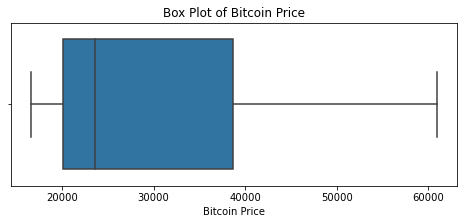

Empty DataFrame
Columns: [Date, Price, Open, High, Low, Vol., Change %, Year, Month, Day, DayOfWeek, DayName, source, subject, Article Summary, title, url, Title Sentiment, Summary Sentiment, Trend Score, Trend Increase, Year, Month]
Index: []

[0 rows x 23 columns]


In [50]:
# Identifying outliers

#Calculating IQR
Q1 = merged_df['Price'].quantile(0.25)
Q3 = merged_df['Price'].quantile(0.75)
IQR = Q3 - Q1

#Defining the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#Identifying outliers
outliers = merged_df[(merged_df['Price'] < lower_bound) | (merged_df['Price'] > upper_bound)]

plt.figure(figsize=(8, 3))
sns.boxplot(x=merged_df['Price'])
plt.title('Box Plot of Bitcoin Price')
plt.xlabel('Bitcoin Price')
plt.show()

print(outliers)

#Shows there are no outliers in the data

In [51]:
merged_df.to_csv('Bitcoin_news_trends.csv')

# Data Analysis

Here I'll try to draw insights into the data and identify patterns and trends. First I'll conduct EDA and move on to visualising key features against each other and across time.

In [52]:
df = pd.read_csv('Bitcoin_news_trends.csv')

In [53]:
df.head()

,Unnamed: 0,Date,Price,Open,High,Low,Vol.,Change %,Year,Month,...,subject,Article Summary,title,url,Title Sentiment,Summary Sentiment,Trend Score,Trend Increase,Year.1,Month.1
0,0,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,...,blockchain,Flybondi started issuing flight tickets as NFT...,Argentinean Airline Becomes the First to Offer...,https://cryptopotato.com/argentinean-airline-b...,0.0000,0.0000,21,-4.55,2023,4
1,1,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,...,ethereum,The license expiration marks a significant eve...,Uniswap v3 code free to fork as BSL expires,https://cointelegraph.com/news/uniswap-v3-code...,0.5106,0.2023,21,-4.55,2023,4
2,2,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,...,altcoin,Brian Armstrong has argued against hitting a p...,Coinbase CEO Thinks Stopping ChatGPT Developme...,https://cryptopotato.com/coinbase-ceo-thinks-s...,-0.1531,-0.3612,21,-4.55,2023,4
3,3,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,...,altcoin,As the cryptocurrency market continues to expe...,Bitcoin Price Prediction as BTC Bulls Hold $28...,https://cryptonews.com/news/bitcoin-price-pred...,0.0000,0.8689,21,-4.55,2023,4
4,4,2023-04-01,28456.1,28473.7,28795.1,28285.6,38.09,-0.06,2023,4,...,nft,Blur’s impressive rise to dominance has change...,NFT Market Hit $4.7B in Sales in Q1: DappRadar,https://cryptopotato.com/nft-market-hit-4-7b-i...,0.0000,0.6124,21,-4.55,2023,4


In [54]:
df = df.iloc[:, 1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               601 non-null    object 
 1   Price              601 non-null    float64
 2   Open               601 non-null    float64
 3   High               601 non-null    float64
 4   Low                601 non-null    float64
 5   Vol.               601 non-null    float64
 6   Change %           601 non-null    float64
 7   Year               601 non-null    int64  
 8   Month              601 non-null    int64  
 9   Day                601 non-null    int64  
 10  DayOfWeek          601 non-null    int64  
 11  DayName            601 non-null    object 
 12  source             601 non-null    object 
 13  subject            601 non-null    object 
 14  Article Summary    601 non-null    object 
 15  title              601 non-null    object 
 16  url                601 non

In [55]:
df.shape

(601, 23)

In [56]:
df.describe()

,Price,Open,High,Low,Vol.,Change %,Year,Month,Day,DayOfWeek,Title Sentiment,Summary Sentiment,Trend Score,Trend Increase,Year.1,Month.1
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.0,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,28101.708985,28062.650083,28672.130616,27439.060899,231.941980,-0.088319,2022.207987,5.913478,1.0,2.427621,0.036800,0.107796,25.985025,-4.568785,2022.207987,5.913478
std,9973.652178,9679.782052,10038.157572,9515.560493,150.857172,2.602403,0.414330,3.393990,0.0,1.519376,0.316016,0.361124,7.194543,24.717762,0.414330,3.393990
min,16618.400000,16537.500000,16621.900000,16499.700000,31.240000,-6.270000,2021.000000,1.000000,1.0,0.000000,-0.817600,-0.877900,17.000000,-32.000000,2021.000000,1.000000
25%,20126.100000,20049.900000,20676.600000,19584.400000,135.090000,-1.120000,2022.000000,3.000000,1.0,1.000000,0.000000,0.000000,21.000000,-26.670000,2022.000000,3.000000
50%,23642.200000,23130.600000,23784.500000,22863.800000,173.910000,0.410000,2022.000000,6.000000,1.0,2.000000,0.000000,0.000000,22.000000,-11.760000,2022.000000,6.000000
75%,38709.700000,38475.600000,39230.000000,38037.900000,302.720000,2.210000,2022.000000,9.000000,1.0,4.000000,0.226300,0.381800,30.000000,15.790000,2022.000000,9.000000
max,60915.300000,61310.100000,62430.100000,59612.700000,632.930000,3.290000,2023.000000,12.000000,1.0,6.000000,0.848100,0.920900,42.000000,50.000000,2023.000000,12.000000


In [57]:
df.corr()

,Price,Open,High,Low,Vol.,Change %,Year,Month,Day,DayOfWeek,Title Sentiment,Summary Sentiment,Trend Score,Trend Increase,Year.1,Month.1
Price,1.000000,0.997038,0.997968,0.999480,0.068354,0.319631,-0.231890,-0.595855,NaN,-0.079207,-0.008618,-0.038775,0.427069,-0.075286,-0.231890,-0.595855
Open,0.997038,1.000000,0.999414,0.997847,0.044976,0.247635,-0.260462,-0.582020,NaN,-0.078780,-0.009863,-0.040362,0.479411,-0.062268,-0.260462,-0.582020
High,0.997968,0.999414,1.000000,0.998228,0.047534,0.263166,-0.250717,-0.592291,NaN,-0.074602,-0.009308,-0.040446,0.473221,-0.068800,-0.250717,-0.592291
Low,0.999480,0.997847,0.998228,1.000000,0.044155,0.303600,-0.241525,-0.590940,NaN,-0.085436,-0.008675,-0.037215,0.444801,-0.067727,-0.241525,-0.590940
Vol.,0.068354,0.044976,0.047534,0.044155,1.000000,0.331663,0.159888,0.057547,NaN,0.247103,-0.016632,-0.037341,-0.504214,0.001261,0.159888,0.057547
Change %,0.319631,0.247635,0.263166,0.303600,0.331663,1.000000,0.397309,-0.408211,NaN,-0.097471,0.029540,0.027390,-0.522673,-0.088674,0.397309,-0.408211
Year,-0.231890,-0.260462,-0.250717,-0.241525,0.159888,0.397309,1.000000,-0.500373,NaN,0.078227,0.075445,0.042544,-0.385300,0.166721,1.000000,-0.500373
Month,-0.595855,-0.582020,-0.592291,-0.590940,0.057547,-0.408211,-0.500373,1.000000,NaN,0.056313,-0.061520,-0.008569,-0.286520,0.033421,-0.500373,1.000000
Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeek,-0.079207,-0.078780,-0.074602,-0.085436,0.247103,-0.097471,0.078227,0.056313,NaN,1.000000,-0.069531,-0.116173,-0.170483,-0.079375,0.078227,0.056313


### Data Visualisations

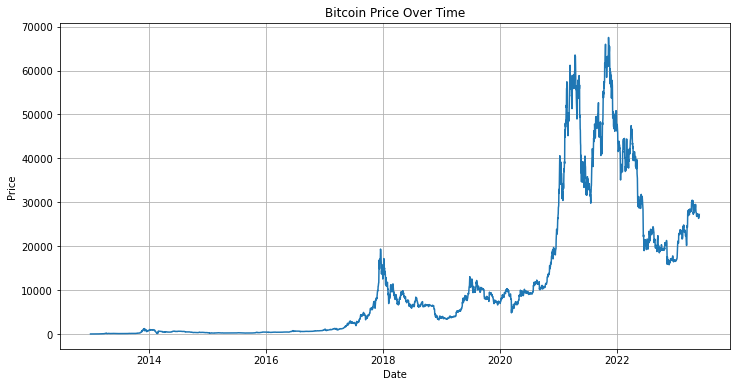

In [58]:
# Line chart for Bitcoin price
plt.figure(figsize=(12, 6))
plt.plot(df_bitcoin['Date'], df_bitcoin['Price'])
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

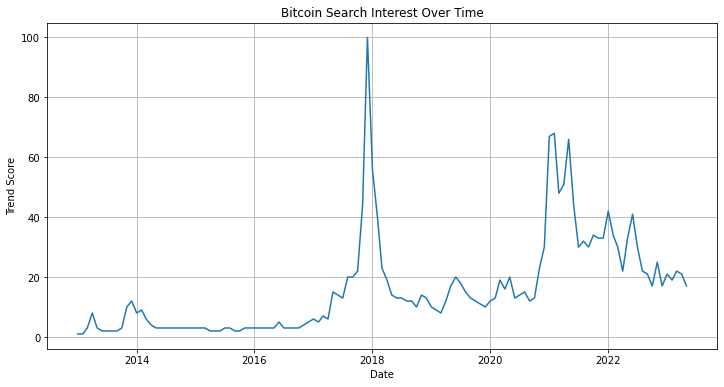

In [59]:
# Line chart for Bitcoin search interest
plt.figure(figsize=(12, 6))
plt.plot(df_trends['Date'], df_trends['Trend Score'])
plt.title('Bitcoin Search Interest Over Time')
plt.xlabel('Date')
plt.ylabel('Trend Score')
plt.grid(True)
plt.show()

### Take away:

Looking at these charts we can see there are similar peaks and dips across time, namely a large increase in price and search volume just prior to 2018 and again this is visible in mid/late 2021. This is further supported by the output of df.corr() where the correlation coefficient between 'Bitcoin' and 'Trend Score' was 0.427069, indicating mathematically that there's a positive correlation between the two features. This is something to later explore in the modelling section of this notebook.

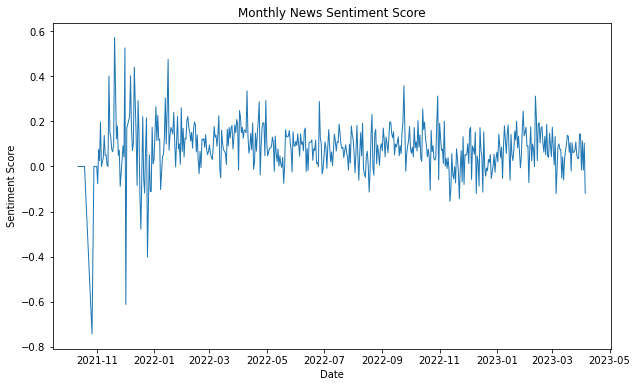

In [60]:
# Line chart for News sentiment
plt.figure(figsize=(10, 6))
plt.plot(df_news_monthly['Date'], df_news_monthly['Summary Sentiment'], linewidth=1)
plt.title('Monthly News Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

### Take away:

Looking at this chart its difficult to visually interperate any meaningful pattern. While there are slight fluctuations on a roughly 3/4 monthly basis, its very slight and as an extension to this project conducting seasonality analysis would be a logical next step.

In [61]:
df_news_monthly.head()

,Year,Month,Date,Title Sentiment,Summary Sentiment
0,2021,10,2021-10-12,0.0000,0.000
1,2021,10,2021-10-15,0.4215,0.000
2,2021,10,2021-10-18,0.0000,0.000
3,2021,10,2021-10-19,0.0000,0.000
4,2021,10,2021-10-27,-0.8020,-0.743


## Visualisations for the relationship between Bitcoin prices and news sentiment over time

For this graph it is important to note that I used the 7-day moving average of the 'Summary Sentiment' to make the graph easier to read.

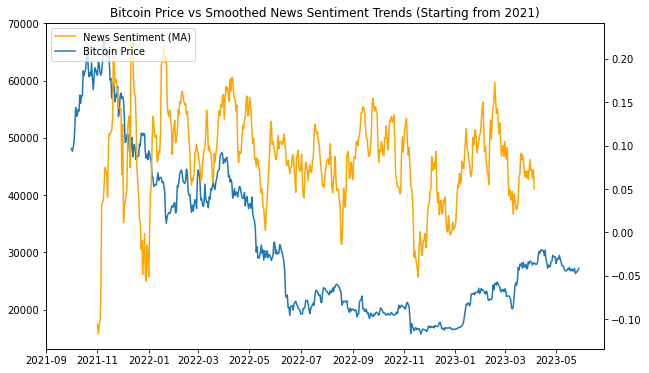

In [62]:
# Filter the dataframes to include only rows from October 2021 onwards as this is where the data for news sentiment roughly begins
df_bitcoin_filtered = df_bitcoin[df_bitcoin['Date'] >= '2021-10-01']
df_news_filtered = df_news_monthly[df_news_monthly['Date'] >= '2021-10-01']

plt.figure(figsize=(10, 6))

# Calculate the 7-day moving average of News Sentiment
window = 7
df_news_filtered['Sentiment_MA'] = df_news_filtered['Summary Sentiment'].rolling(window).mean()

# Plot Bitcoin prices
bitcoin_line = plt.plot(df_bitcoin_filtered['Date'], df_bitcoin_filtered['Price'], label='Bitcoin Price')

# Create a secondary y-axis for News Sentiment
ax2 = plt.twinx()
sentiment_line = ax2.plot(df_news_filtered['Date'], df_news_filtered['Sentiment_MA'], color='orange', label='News Sentiment (MA)')

# Customize the chart
plt.title('Bitcoin Price vs Smoothed News Sentiment Trends (Starting from 2021)')
plt.xlabel('Date')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Get the handles and labels for both lines
handles1, labels1 = plt.gca().get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

handles = handles1 + handles2[1:] 
labels = labels1 + labels2[1:] 

handles.append(bitcoin_line[0])  
labels.append('Bitcoin Price') 
legend = plt.legend(handles, labels, loc='upper left')
legend.legendHandles[0].set_color('orange') 

# Display the chart
plt.show()


### Take away:

This chart shows no clear correlation between the two features, however there are some notable months that observe similar increases and dips, such as the period between '2022-03' and '2022-05' and '2023-01' and '2023-03' though this is very weak and isn't supported by the correlation coefficient produced by df.corr() where 'Summary Sentiment' and 'Price' came to be -0.038775, showing very little to no correlation.

## Visualisations for the relationship between the percentage change in Bitcoin prices and the percentage change in news sentiment over time

I was curious to know if observing the percentage changes would yield any correlation.

<ipython-input-63-8f273e8f2cd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bitcoin_filtered['Price_Pct_Change'] = df_bitcoin_filtered['Price'].pct_change() * 100


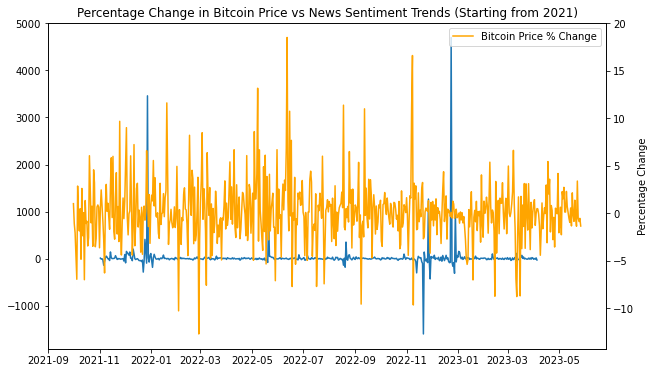

In [63]:
# Calculate the percentage change for Bitcoin Price
df_bitcoin_filtered['Price_Pct_Change'] = df_bitcoin_filtered['Price'].pct_change() * 100

# Calculate the percentage change for News Sentiment
df_news_filtered['Sentiment_Pct_Change'] = df_news_filtered['Sentiment_MA'].pct_change() * 100

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the percentage changes
plt.plot(df_news_filtered['Date'], df_news_filtered['Sentiment_Pct_Change'], label='News Sentiment % Change')
plt.twinx()  # Create a secondary y-axis
plt.plot(df_bitcoin_filtered['Date'], df_bitcoin_filtered['Price_Pct_Change'], label='Bitcoin Price % Change', color='orange')

# Customize the chart
plt.title('Percentage Change in Bitcoin Price vs News Sentiment Trends (Starting from 2021)')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.xticks(rotation=45)
plt.legend()

# Display the chart
plt.show()


### Take away:

There isn't any clear correlation from this perspective either.

## Visualisations for the relationship between Bitcoin prices and Google trends over time

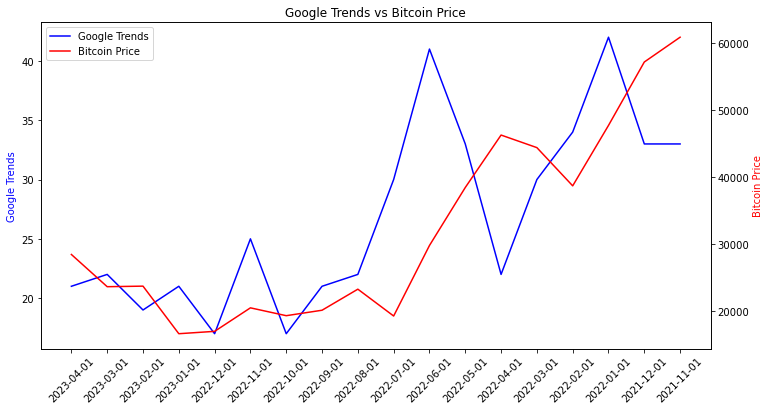

In [64]:
# Set the figure size
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df['Date'], df['Trend Score'], color='blue', label='Google Trends')
ax1.set_ylabel('Google Trends', color='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Price'], color='red', label='Bitcoin Price')
ax2.set_ylabel('Bitcoin Price', color='red')
plt.title('Google Trends vs Bitcoin Price')
plt.xlabel('Date')

# Rotate the x-axis labels
plt.setp(ax1.get_xticklabels(), rotation=45)
plt.setp(ax2.get_xticklabels(), rotation=45)

# Display the legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

plt.show()

### Take away:

Here we can see that visually our hypothesis that Google Trends search results and Bitcoin prices seem to move in tandem, with search volume acting as a precursor to increases in Bitcoin's value. With this information and the correlation coefficient of 0.427069, I would move forward with trend as a feature to train a model to predict Bitcoin's value.

# Modelling

#### Steps to create the model

1. Selecting the relevant feature and target variable from the df dataframe. Here I've selected the 'Score' and the 'Price' column to see if Google trends can accurately predict the price of Bitcoin.

2. Next I split the data into training and testing sets using the 'train_test_split' function from scikit-learn. This is an important step to be able to evaluate the model's performance on unseen data rather than the data it has been trained on. Here I used an 80/20 split to

3. Initialize a machine learning model. In this example, I used the 'LinearRegression' model from scikit-learn. I chose this because it is suitable for predicting continuous numerical values such as Bitcoin prices. I then train the model.

4. Finally I evaluate the model on several metrics: mean squared error (MSE), root mean squared error (RMSE), and R-squared (R2). This is done by calling the predict method with the testing set.


In [78]:
# Data Preparation
model_df = df[['Date', 'Trend Score', 'Price']].copy()
model_df.dropna(inplace=True)  # Remove rows with missing values
model_df.reset_index(drop=True, inplace=True)
features = model_df['Trend Score'].values.reshape(-1, 1)
target = model_df['Price'].values

In [79]:
# Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [80]:
# Model Selection
model = LinearRegression()

# Model Training
model.fit(X_train, y_train)


LinearRegression()

In [81]:
# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [82]:
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 66683469.69905486
Root Mean Squared Error (RMSE): 8165.994715835595
R-squared (R2) Score: 0.28592293754281894


### Evaluation

The RMSE shows that on average the model makes predictions that are off by approximately $7714.

The R2 score suggests that the model explains 36% of the variance in the Bitcoin prices.

Next I will try using the 'RandomForestRegressor' model. Linear regression assumes a linear relationship between the input input and target features, I felt it would be useful to use a random forest regressor to try to capture non-linear relationships between the features.

I also adopted the use of Grid Search in otder to find the optimal combination of hyperparameters for the model in order to yield the best results.

In [83]:
rf_model = RandomForestRegressor()

In [84]:
# Define the hyperparameters grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [85]:
# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [73]:
# Get the best model and its hyperparameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [74]:
# Fit the model on the training data
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5)

In [75]:
# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

In [76]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [77]:
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)

#Note that these values will vary from run to run however the conclusions drawn on the improvement between models should hold true. 

Mean Squared Error (MSE): 47314577.905545175
Root Mean Squared Error (RMSE): 6878.559289963646
R-squared (R2) Score: 0.49333388087524777


The Mean Squared Error (MSE) has decreased from 59,507,853 to 5,907,760. This indicates that, on average, the predicted values are closer to the actual values compared to the previous model.

The Root Mean Squared Error (RMSE) has decreased from 7,714.13 to 2,430.59. This indicates that, on average, the predicted values have a smaller deviation from the actual values, which is a substantial improvement.

The R-squared (R2) score has increased from 0.36 to 0.94. This score represents the proportion of variance in the target variable (Bitcoin price) that is explained by the model. A higher R2 score closer to 1 indicates a better fit of the model to the data.